In [1]:
from __future__ import division

%matplotlib notebook
#%matplotlib inline
import time
import random
import numpy as np
# from scipy.stats import norm
import scipy.io as sio
# import matplotlib as mpl
# from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import collections as mc
from scipy.stats import multivariate_normal as mvn
from math import atan2, log
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
import copy
import datetime

# from IPython.display import display, Markdown, Latex

from roadmap import Roadmap
# from pf import PF
# from rbpf import RBPF


In [2]:
# target
class Particle(object):
    def __init__(self, roadmap, v0, dt, e0=None, x0=None, sigma=0.1):
        """A Particle contains the state and dynamic model of one hypothesis of a vehicle location.
        
        The particle's state consists of which road segment the vehicle is on and how far along 
        that road segment the vehicle is, on a scale of 0 to 1. The particle also stores its 
        nominal velocity and noise characteristics.
        
        roadmap -- object containing a graph describing the network of roads
        
        """
        # current edge
        self._roadmap = roadmap
        if e0 is None:
            options = []
            for start in self._roadmap.graph.keys():
                for dest in self._roadmap.graph[start].keys():
                    if (start, dest) not in options:
                        options.append((start, dest))
#             a = random.choice(list(self._roadmap.graph.keys()))
#             b = random.choice(list(self._roadmap.graph[a].keys()))
#             print(len(options))
            chosen = random.choice(options)
#             print(chosen)
            self._e = chosen#(a, b)
        else:
            self._e = e0
        self._e_len = self._roadmap.graph[self._e[0]][self._e[1]]
        # current position on edge 
        if x0 is None:
            self._x = random.random()
        else:
            self._x = x0
        self._v = v0
        self._sigma = sigma
        self._dt = dt
        self.split = 0
        
    def predict(self):
        """Propogate the particle's state based on its dynamics and the roadmap
        
        When a particle is updated, it moves along the road segment by v0*dt, normalized by the 
        length of its current road. If it reaches the end of the road (x >= 1), it queries the
        roadmap for other roads that connect to the current intersection and chooses one at
        random.
        """
        n = 0#np.random.normal(scale=self._sigma)
        self._x += (self._v + n)*self._dt/self._e_len
        self.split = 0
        
        if self._x >= 1.:
            dest_list = list(self._roadmap.graph[self._e[1]].keys())
            # no U-turns
            dest_list.remove(self._e[0])
            self.split = len(dest_list)
            self._e = (self._e[1], random.choice(dest_list))
            self._e_len = self._roadmap.graph[self._e[0]][self._e[1]]
            self._x -= 1
            
        return self.state
        
    @property
    def state(self):
        return (self._e, self._x)
    
    @state.setter
    def state(self, new_state):
        e = new_state[0]
        x = new_state[1]
        try:
            self._roadmap.graph[e[0]][e[1]]
            self._e = e
        except KeyError:
            raise ValueError("Invalid roadmap edge.")
        if x < 0.:
            self._x = 0.
        elif x > 1.:
            self._x = 1.
        else:
            self._x = x
        
    @property
    def loc(self):
        return self._roadmap.get_loc(self.state)

In [3]:
# Variance and Entropy calculations
def calc_entropy(r, X, res=1):
    """Returns the entropy of the estimate in nats
        
        r -- roadmap graph on which the particles exist
        X -- state of each particle, shape=(M, N, 12),
             M = number of targets
             N = number of particles
        """
    
    ## x, y, speed, start_x, start_y, end_x, end_y, direction_x, direction_y, distance, sigma, w
    M = X.shape[0]
    N = X.shape[1]
    # calculate the distance of each particle from the beginning of its road segment
    dists = np.linalg.norm(X[:, :, :2] - X[:, :, 3:5], axis=-1)
    dists_reverse = np.linalg.norm(X[:, :, :2] - X[:, :, 5:6], axis=-1)
    
    h = 0.0
    hist = []
    nodes_visited = []
    counts = []
    probs = []
    for start in r.keys():
#         if start not in nodes_visited:
#             nodes_visited.append(start)
            for end in r[start].keys():
#                 if end not in nodes_visited:
#                     nodes_visited.append(end)
                length = r[start][end]
                bin_start = 0.0
#                 bin_start_reverse = 1.0
                # find the particles on this road segment
                on_edge = np.all(X[:, :, 3:7] == start + end, axis=-1)
#                 on_edge_reverse = np.all(np.flip(X[:, :, 3:7], axis=2) == end + start, axis=-1)
                while bin_start < length:
                    in_bin = np.all([dists >= bin_start, dists <= bin_start + res], axis=0)
#                     in_bin_reverse = np.all([dists_reverse >= bin_start, dists_reverse <= bin_start + res], axis=0)

                    count = np.sum(np.all([on_edge, in_bin], axis=0))# + np.sum(np.all([on_edge, in_bin_reverse], axis=0))
                    counts.append(count)
                    p = count / (N*M)
                    probs.append(p)
                    hist.append(p)
                    if p > 0:
                        h -= p*np.log(p)
                    bin_start += res
#     get_vel_var(X)
#     print(len(counts), len(probs))
    return h, get_pos_var(X), counts, probs

def get_pos_var(X):
    return max(np.var(X[:,:,0:1]), np.var(X[:,:,1:2]))

def get_vel_var(X):
    return np.var(X[:,:,2:3])

def getProb(variance, mean, pos):
    p = np.multiply((1/np.sqrt(2*np.pi*variance)), np.exp(-(pos-mean)/(2*variance)))
    return p

def getPredictedEntropy(variance, mean, max_distance, segment_size):
    entropy = 0
    for pos in range(0, max_distance, segment_size):
#         print(pos)
        p = getProb(variance, mean, pos)
        entropy -= p*np.log(p)
    return entropy

In [4]:
def getEntropy(probability, mode_probability):
    entropy = 0
    for num_modes in mode_probability.keys():
        entropy += mode_probability[num_modes]*sum(-probability[probability>0]*np.log((1/num_modes)*probability[probability>0]))
    return entropy

def getProbAndEntropy(variance, x, mu, mode_probability):
    probability = 1./np.sqrt(2*np.pi*variance)*np.exp(-(x-mu)**2/(2*variance))
    entropy = getEntropy(probability, mode_probability)
    return probability, entropy

def getProbAndEntropyOverTime(var_0, map_size, dt, sigma, num_steps, mode_probability):
    mu = map_size/2.
    distance = np.array([idx for idx in range(map_size)])
    prob_over_time = []
    entropy_over_time = []
    for idx in range(num_steps):
        var = var_0 + idx*(dt*sigma)**2
        prob, entropy = getProbAndEntropy(var, distance, mu, mode_probability[idx])
        prob_over_time.append(prob)
        entropy_over_time.append(entropy)
    return prob_over_time, entropy_over_time
    

In [5]:
class PF(object):
    def __init__(self, roadmap, num_particles, dt, v0=10., sigma=4, x0=None, P_fa=0.1, P_miss=0.05, uturns=False):
        self._roadmap = roadmap
        self._N = num_particles
        self._v0 = v0
        self._uturns = uturns
        # particle shape
        ## x, y, speed, start_x, start_y, end_x, end_y, direction_x, direction_y, distance, sigma, w
        self.X = np.ndarray(shape=(self._N, 12))
        
        if x0 is None:
            #uniformly distribute the particles on the roadway
            for i in range(self._N):
                a = random.choice(list(self._roadmap.graph.keys()))
                b = np.array(random.choice(list(self._roadmap.graph[a].keys())))
                a = np.array(a)
                vector = b - a
                loc = a + vector * random.random()
                distance = np.linalg.norm(vector)
                vector = vector/distance
                self.X[i] = [loc[0], loc[1], v0, a[0], a[1], b[0],
                                      b[1], vector[0], vector[1], distance, sigma, 1/self._N]

        else:
            raise NotImplementedError

        self.best = self.X[0]
        self._dt = dt
        self._P_fa = P_fa
        self._P_miss = P_miss
    
    def get_particle_distance_from_target(self, loc, acceptable_distance):
        avg = 0
        num_in_distance = 0
        dist = np.linalg.norm(self.X[:,0:2] - loc, axis=1)
        num_in_distance = len(np.where(dist < acceptable_distance)[0])
        avg = np.average(dist)
        return avg, num_in_distance

    def get_max_particle_density(self):
        overall_avg = 0
        min_avg = 9999999999
        for i in range(len(self.X)):
            dist = np.linalg.norm(self.X[:,0:2] - self.X[i,0:2], axis=1)
            avg_dist = np.average(dist)
            overall_avg += avg_dist
            if avg_dist < min_avg:
                min_avg = avg_dist
        return overall_avg, min_avg

    def get_edge_particle_density(self):
        edges = {}
        edges_present, count = np.unique(self.X[:, 3:7], return_counts=True, axis=0)
        for i in range(len(edges_present)):
            start_edge = (edges_present[i][0], edges_present[i][1])
            end_edge = (edges_present[i][2], edges_present[i][3])
            edges[(start_edge, end_edge)] = count[i]
        return edges

    def get_measurement_likelihood(self, z, R):
        return np.sum(mvn.pdf(self.X[:,:2], z, R))

    def low_var_sample(self):
        M = self._N
        r = np.random.uniform(0,1/M)
        c = self.X[0,11]
        new_particles = np.zeros_like(self.X)
        i = 0
        last_i = 1
        unique = 1
        insert_index = 0
        for m in range(M):
            u = r + m/M
            while u > c:
                i += 1
                c = c + self.X[i,11]
            new_particles[insert_index] = copy.deepcopy(self.X[i])
            insert_index += 1
            if last_i != i:
                unique += 1
            last_i = i
        self.X = new_particles
        return unique

    def predict(self, timestep=1):
#         old_particles = deepcopy(self.X)
        n = np.random.normal(scale=self.X[:,10:11])
        loc = self.X[:,0:2]
        vector = self.X[:,7:9]
        speed = self.X[:,2:3]
        loc[...] += vector * ((speed + n) * timestep * self._dt)
        update_vector = np.linalg.norm(self.X[:,0:2] - self.X[:,3:5], axis=1) \
            > self.X[:,9]

        for i in np.where(update_vector)[0]:
            dist = np.linalg.norm(self.X[i,0:2] - self.X[i,3:5]) - self.X[i,9]
            a = (self.X[i,3], self.X[i,4])
            b = (self.X[i,5], self.X[i,6])

            dest_list = list(self._roadmap.graph[b].keys())
            if not self._uturns:
                dest_list.remove(a)
            a = self.X[i,5:7]
            b = np.array(random.choice(dest_list))
            vector = b - a
            distance = np.linalg.norm(vector)
            vector = vector/distance
            loc = a #(a[0] + vector[0]*dist, a[1] + vector[1]*dist)
            self.X[i,0:10] = [loc[0], loc[1], self._v0, a[0], a[1], b[0],
                           b[1], vector[0], vector[1], distance]
        
    def update(self, z, R, p_fa=None):
        weight_addon = self._P_fa/self._roadmap.total_length
        w = (1. - self._P_fa)*mvn.pdf(self.X[:,0:2], z, R) + weight_addon
        
        
        w = np.log(w)

        max_w = np.max(w)
        w = np.exp(w-max_w)
        # for code simplicity, normalize the weights here
        w = w/np.sum(w)

        self.best_idx = np.argmax(w)  
        self.best = self.X[self.best_idx]
        self.X[:,11] = w

        unique = self.low_var_sample()

    def neg_update(self, z, radius):
        self.X[:,11] = 1
        update_vector = np.linalg.norm(self.X[:,0:2] - z, axis=1) < radius
        self.X[update_vector,11] = self._P_miss
        self.X[:,11] /= np.sum(self.X[:,11])
        unique = self.low_var_sample()


class RB_PF(object):
    def __init__(self, roadmap, num_particles, max_vehicles, pf_args):
        self._roadmap = roadmap
        self._N = num_particles
        self._max_vehicles = max_vehicles
        self.X = [[PF(**pf_args) for j in range(self._max_vehicles)] for i in range(self._N)]
        self.best = self.X[0]
        self.no_measurements = True
        
    def lowVarSample(self, w):
        Xbar = []
        M = self._N
        r = np.random.uniform(0, 1/M)
        c = w[0]
        i = 0
        last_i = i
        unique = 1
        for m in range(M):
            u = r + m/M
            while u > c:
                i += 1
                c = c + w[i]
            new_x = copy.deepcopy(self.X[i])
            Xbar.append(new_x)
            if i == self.best_idx:
                self.best = new_x
            if last_i != i:
                unique += 1
            last_i = i
        self.X = Xbar
        return unique

    def predict(self):
        # propagate each bank of particle filters
        [[xi.predict() for xi in x] for x in self.X]
       
        
    def update(self, z, R, lone_target, radius=None, p_fa=None):
#         print("updating")
        w = np.zeros(self._N)
        
        

        for i, x in enumerate(self.X):
            if self.no_measurements:
                t = 0
            else:
                # get the likelihood that the measurement came from each target
                l = np.array([xi.get_measurement_likelihood(z, R) for xi in x])

                # normalize the likelihoods so we can randomly choose a corresponding target
                # with some smart probabilites
                l = l/np.sum(l)
                t = np.where(np.random.multinomial(1, l) == 1)[0][0]
    #             print(t)
            w[i] = x[t].get_measurement_likelihood(z, R)
            x[t].update(z, R)
            if lone_target:
                for j, xi in enumerate(x):
                    if t != j:
                        xi.neg_update(z, radius)
        self.no_measurements = False
            
            
        # logsumexp
        max_w = np.max(w)
        w = np.exp(w-max_w)
        # for code simplicity, normalize the weights here
        w = w/np.sum(w)
#         print("best: {}={}".format(np.argmax(w), np.max(w)))
        
        self.best_idx = np.argmax(w)        
        self.best = self.X[self.best_idx]
        unique = self.lowVarSample(w)
#         print(unique)

    
    def neg_update(self, z, radius):
        [[xi.neg_update(z, radius) for xi in x] for x in self.X]

In [6]:
def sim(rbpf, r, targets, agent, R, dt, T_end, agent_updates=False, all_data=False, plot=True, entropy_res=1):
    if plot:
        fig, ax = plt.subplots()
        r.visualize(ax)

        x0 = rbpf.best[0].X[:,0]
        y0 = rbpf.best[0].X[:,1]
        sc1 = ax.scatter(x0, y0, s=10, linewidth=0, facecolor='green', label='particles')
        loc = r.get_loc(targets[0].state)
        sc_target1 = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='green', label='target')

    #     x0 = rbpf.best[1].X[:,0]
    #     y0 = rbpf.best[1].X[:,1]
    #     sc2 = ax.scatter(x0, y0, s=10, linewidth=0, facecolor='blue', label='particles')
    #     loc = r.get_loc(target2.state)
    #     sc_target2 = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='blue', label='target')
#         agent.init_plot(ax)
        ax.legend()
        #ax.plot([50, 60], [50, 50], marker='o', ls='None')

        ax.set_xlim(-20, 450)
        ax.set_ylim(-20, 320)
        ax.set_aspect('equal')
        # plt.plot([0,1,1,2])
        # plt.show()
        fig.canvas.draw()
        start = time.time()
        tic = start
    H = []
    Ts = dt
    avg_distance = [[] for pf in rbpf.best]
    num_in_threshold = [[] for pf in rbpf.best]
    if all_data:
        variances = []
        counts = []
        probs = []
        particles = []
    for i in range(15):
        targets[0].predict()
        rbpf.predict()
        rbpf.update(mvn.rvs(targets[0].loc, R), R, lone_target=True, radius=1)
    
    # update the scenario
    for i in range(int(T_end/Ts)):
#     for i in tqdm(range(int(T_end/Ts))):
        rbpf.predict()
        dists = []
        for target in targets:
            target.predict()
            dists.append(np.linalg.norm(target.loc - agent.pos))
        if agent_updates:
            if i % int(1/Ts) == 0 and i != 0:
    #             if (dist1 < agent.fov) != (dist2 < agent.fov):
                if dists[0] < agent.fov:
                    z = mvn.rvs(targets[0].loc, R)
                    rbpf.update(z, R, lone_target=True, radius=agent.fov*0.75)
    #                 if dist2 < agent.fov:
    #                     z = mvn.rvs(target2.loc, R)
    #                     rbpf.update(z, R, lone_target=True, radius=agent.fov*0.75)
    #             elif (dist1 < agent.fov) and (dist2 < agent.fov):
    #                     z = mvn.rvs(target1.loc, R)
    #                     rbpf.update(z, R, lone_target=False)
    #                     z = mvn.rvs(target2.loc, R)
    #                     rbpf.update(z, R, lone_target=False)
                else:
                    rbpf.neg_update(agent.pos, radius=agent.fov*0.75)
        if plot:
            locs1 = rbpf.best[0].X[:,:2]
            sc1.set_offsets(locs1)
    #         locs2 = rbpf.best[1].X[:,:2]
    #         sc2.set_offsets(locs2)
            sc_target1.set_offsets(targets[0].loc)
    #         sc_target2.set_offsets(target2.loc)
            pfs = rbpf.best
        pfs = rbpf.best
        if agent_updates:
            agent.update(pfs)
        if plot:
            fig.canvas.draw()
            toc = time.time()
            dur = toc - tic
            tic = toc
        X = np.array([rbpf.best[i].X for i in range(len(rbpf.best))])
        H_current, var_pos, part_dist, p = calc_entropy(r.graph, X, res=entropy_res)
        H += [H_current]
        if all_data:
            variances.append(var_pos)
            counts += [part_dist]
            probs += [p]
            particles += [X]
        elif i==0:
            variance_0 = var_pos
    if all_data:
        return H, variances, counts, probs, particles
    else:
        return H, variance_0

def runIterations(nodes, edges, N, dt, T_end, num_runs, P_fa=.02, P_miss=.05,
                  v0=4.5, sigma=4, num_targets=1, e0=None, x0=None, agent_updates=False,
                  all_data=False, plot=False, uturns=False, entropy_res=1, particles_only=False):
    r = Roadmap(nodes, edges, rotate=False)
    pf_args = {'roadmap':r, 'num_particles':N, 'dt':dt, 'v0':v0, 'sigma':4,
               'P_fa':P_fa, 'P_miss':P_miss, 'uturns':uturns}
    R = 5*np.eye(2)
    H = []
    variances = []
    particles = []
    if all_data:
        counts = []
        probs = []
    for idx in tnrange(num_runs):
        rbpf = RB_PF(r, 1, num_targets, pf_args)
        targets = []
        for jdx in range(num_targets):
            if x0 is not None:
                targets.append(Particle(r, v0=v0, dt=dt,e0=e0[jdx], x0=x0[jdx], sigma=sigma))
            else:
                targets.append(Particle(r, v0=v0, dt=dt, sigma=sigma))
        
        agent = AgentRandom((100, 60), 100, 50, 40, 30, r, dt=dt)
        if all_data:
            H_tmp, variance, count, prob, part = sim(rbpf, r, targets, agent, R, dt, T_end, all_data=all_data,
                                               plot=plot, entropy_res=entropy_res)
            H += [H_tmp]
            variances += [variance]
            counts += [count]
            probs += [prob]
#             particles += [part]
        else:
            H_tmp, variance_0 = sim(rbpf, r, targets, agent, R, dt, T_end, all_data=all_data, plot=plot,
                                    entropy_res=entropy_res)
            H += [H_tmp]
            variances += [variance_0]
    h = np.mean(H, axis=0)
    v = np.mean(variances, axis=0)
    if particles_only:
        return np.array(particles)
    elif all_data:
        c = np.mean(counts, axis=0)
        p = np.mean(probs, axis=0)
        return h, v, c, p#, np.array(particles)
    else:
        return h, v

In [7]:

class AgentRandom(object):
    def __init__(
        self, center, width, height, speed, period,
        roadmap, dt, fov=30.):
        self._c = center
        self._w = width
        self._h = height
        self._period = period
        self.pos = np.array(center)
        self._roadmap = roadmap
        dest = self._roadmap.get_nearest_waypoint(self.pos)
        self.psi = atan2(dest[0] - self.pos[0], dest[1] - self.pos[1])
        self._dt = dt
        self._t = 0
        self._sc_agent = None
        self._sc_fov = None
        self.speed = speed
        self.fov = fov
        self.path = [dest]
        self.current_dest = 0
        self.discount = .8

    def update(self, pfs):
#         ##Dummy version of path planning
#         self._t += self._dt
#         self.pos = np.array((self._w*np.cos(2*np.pi*self._t/self._period) + self._c[0], 
#                              self._h*np.sin(2*2*np.pi*self._t/self._period) + self._c[1]))
#         if self._sc_agent is not None:
#             self.update_plot()
            
        ##inteligent path planning
        self._t += self._dt
        distance = np.array((
            self.path[self.current_dest][0] - self.pos[0],
            self.path[self.current_dest][1] - self.pos[1]))
        
        if abs(distance[0]) > abs(distance[1]):
            distance[1] *= 20
        elif abs(distance[1]) > abs(distance[0]):
            distance[0]*= 20
        
        vel = self.speed * (distance / np.linalg.norm(distance) )
        self.pos = self.pos + np.array(vel * self._dt)

        if self._sc_agent is not None:
            self.update_plot()
        if np.linalg.norm(distance) < 20:
            self.update_path(pfs)

    def update_path(self, pfs):
        destinations = list(self._roadmap.graph[self.path[self.current_dest]].keys())
        self.path.append(random.choice(destinations))
        self.current_dest += 1

    def init_plot(self, ax):
        self._sc_agent = ax.scatter([self.pos[0]], [self.pos[1]], s=50, marker='D', facecolor='red', label='agent')
        self._sc_fov = plt.Circle((self.pos[0], self.pos[1]), self.fov, facecolor='None', edgecolor='orange')
        ax.add_patch(self._sc_fov)
    
    def update_plot(self):
        self._sc_agent.set_offsets([self.pos])
        self._sc_fov.center = self.pos[0], self.pos[1]


# Calculate entropy based off of known Variance

In [33]:

dist_e = 900
nodes = [(0.,0.), (dist_e,0.)]

edges = [(0, 1)]
N = 100
dt = .1
T_end = 100
num_runs = 1
sigma = 4
v0 = 5
h, v, c, p = runIterations(nodes, edges, N, dt, T_end, num_runs, sigma=sigma, v0=v0,
                           e0=[(nodes[1], nodes[0])], x0 = [.03], uturns=True, all_data=True)

In [34]:
sigma = 4
predicted_v = [v[0]]
mu = 100
max_dist = 100
x = np.array([i for i in range(int(mu-max_dist),int(mu+max_dist),1)])
ent = []
predicted_ent = []
p_by_time = []
p_est_by_time = []
predicted_est_by_time = []
bias = 0
first_split = 270
second_split = 388
mode_probability = [{1: 1} for idx in range(v.shape[0])]
predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(v[0], 100, dt, sigma, v.shape[0], mode_probability)
for idx in range(v.shape[0]):
    #calculate entropy and probability based on variance
    var = v[idx]
    mode_probability = {1:1}
    est, entropy = getProbAndEntropy(var, x, mu, mode_probability)
#     print(entropy)
    p_est_by_time.append(est)
    ent.append(entropy)
    
p_est_by_time = np.array(p_est_by_time)
#rk4
# 0 order whole

In [35]:
# Give plotted data unique variable names
from scipy.io import savemat
first_plot = {
    'v':v,
    'predicted_v':predicted_v,
    'p': p,
    'p_est_by_time': p_est_by_time,
    'predicted_est_by_time': predicted_est_by_time,
    'ent': ent,
    'h': h,
    'predicted_ent': predicted_ent
}
savemat('pdf1.mat', first_plot)
#

<IPython.core.display.Javascript object>


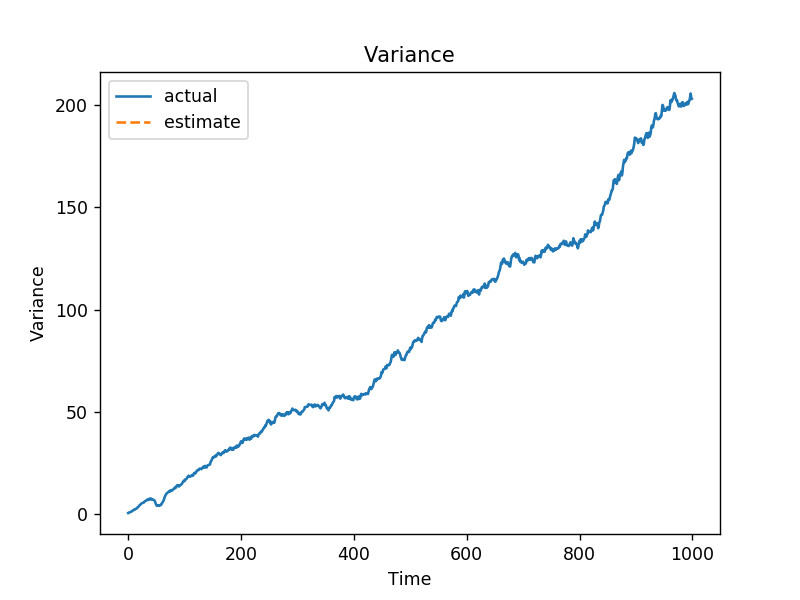

<IPython.core.display.Javascript object>


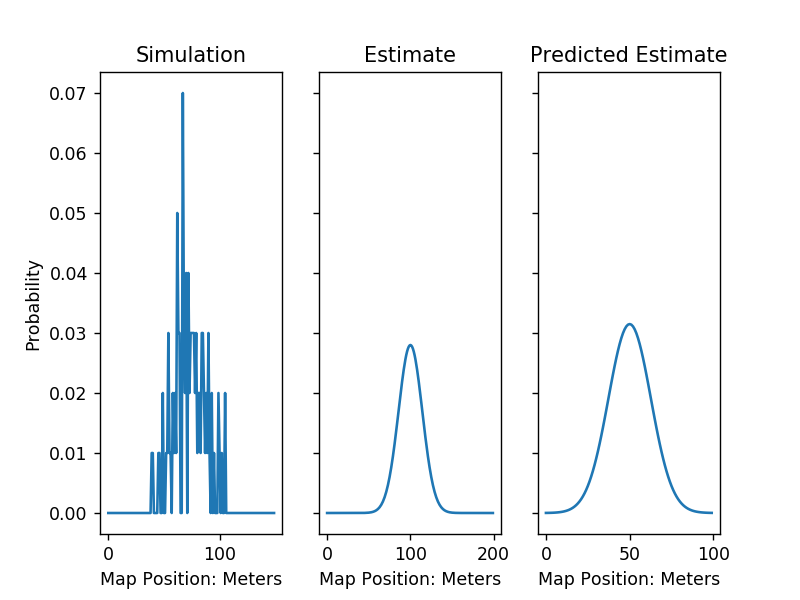

In [41]:
fig, ax = plt.subplots()
ax.set_title("Variance")
ax.plot(first_plot['v'], label='actual')
ax.plot(first_plot['predicted_v'], '--', label='estimate')
ax.set_ylabel('Variance')
ax.set_xlabel('Time')
ax.legend()
fig, ax = plt.subplots(1,3, sharey='row')
ax[0].set_ylabel("Probability")
ax[0].set_title('Simulation')
ax[1].set_title('Estimate')
ax[2].set_title('Predicted Estimate')
ax[0].set_xlabel('Map Position: Meters')
ax[1].set_xlabel('Map Position: Meters')
ax[2].set_xlabel('Map Position: Meters')
sim_x = np.array([i for i in range(int(mu-max_dist),int(mu+max_dist))])
# for idx in range(v.shape[0]):
idx = -1
ax[0].plot(np.array(first_plot['p'][idx][1300:1450]))
ax[1].plot(first_plot['p_est_by_time'][idx])
ax[2].plot(first_plot['predicted_est_by_time'][idx])

# fig, ax = plt.subplots()
# ax.set_title("Entropy over Time")
# ax.set_ylabel("Entropy")
# ax.set_xlabel("Time")
# ax.plot(first_plot['ent'],label='continus calculation')
# ax.plot(first_plot['h'], label='simulation')
# ax.plot(first_plot['predicted_ent'], label='continuous calculation from predicted entropy')
# ax.legend()
# data = []
# data.append((max(first_plot['p'][idx]),
#              max(first_plot['p_est_by_time'][idx]),
#              max(first_plot['predicted_est_by_time'][idx])))
# print(np.array(data))

## Predict positional variance based off the variance in velocity

In [ ]:

dist_e = 100.
nodes = [(0.,0.), (dist_e,0.), ( 2*dist_e, 0),
         (0.,dist_e), (dist_e, dist_e), (2*dist_e, dist_e)]#,

edges = [(0, 1), (1,2), (0,3), (1,4), (2,5), (3,4), (4,5)]#, (3,6), (4,7), (5,8), (6,7), (7,8)]

N = 1000
dt = 0.1
T_end = 10
num_runs = 1000

P_fa = 0.02
P_miss = 0.05
v0 = 10
sigma = 4
pf_args = {'num_particles':N, 'dt':dt, 'v0':v0, 'sigma':sigma, 'P_fa':P_fa, 'P_miss':P_miss}
particles = runIterations(nodes, edges, N, dt, T_end, num_runs, P_fa, P_miss, v0=v0, sigma=sigma,
                     e0=[(nodes[0], nodes[1])], x0 = [.5], num_targets=1, all_data=True, plot=False, particles_only=True)
# h, v, c, p, particles = runIterations(nodes, edges, N, dt, T_end, num_runs, P_fa, P_miss, v0=v0, sigma=sigma,
#                      e0=[(nodes[0], nodes[1])], x0 = [.5], num_targets=1, all_data=True, plot=False, particles_only=True)

In [261]:
split_0 = 270
split_1 = 370
split_2 = 570
split_3 = 770
split_4 = 870
split_5 = 970
split_6 = 1080
split_7 = 1180
mode_probability = [{1: int(idx<split_0),
                     2*.95:int(idx>=split_0 and idx < split_1),
                     3*.95*.95:int(idx>=split_1 and idx < split_2),
                     3.5:int(idx >= split_2 and idx < split_3),
                     4: int(idx >= split_3 and idx < split_4),
                     4.5: int(idx >= split_4 and idx < split_5),
                     4.6: int(idx >= split_5 and idx < split_6),
                     4.7: int(idx >= split_6)
                    } for idx in range(h.shape[0])
                   ]
predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(v, 100, dt, sigma, h.shape[0], mode_probability)

mode_probability = [{1: int(idx<split_0),
                     2:int(idx>=split_0 and idx < split_1),
                     3:int(idx>=split_1 and idx < split_2),
                     4:int(idx >= split_2 and idx < split_3),
                     5: int(idx >= split_3 and idx < split_4),
                     6: int(idx >= split_4 and idx < split_5),
                     7: int(idx >= split_5 and idx < split_6),
                     8: int(idx >= split_6)
                    } for idx in range(h.shape[0])
                   ]
predicted_est_by_time, predicted_ent_raw = getProbAndEntropyOverTime(v, 100, dt, sigma, h.shape[0], mode_probability)


In [ ]:
###### 

In [172]:
second_plot = {
    'h': h,
    'predicted_ent': predicted_ent,
    'v': v
}

<IPython.core.display.Javascript object>


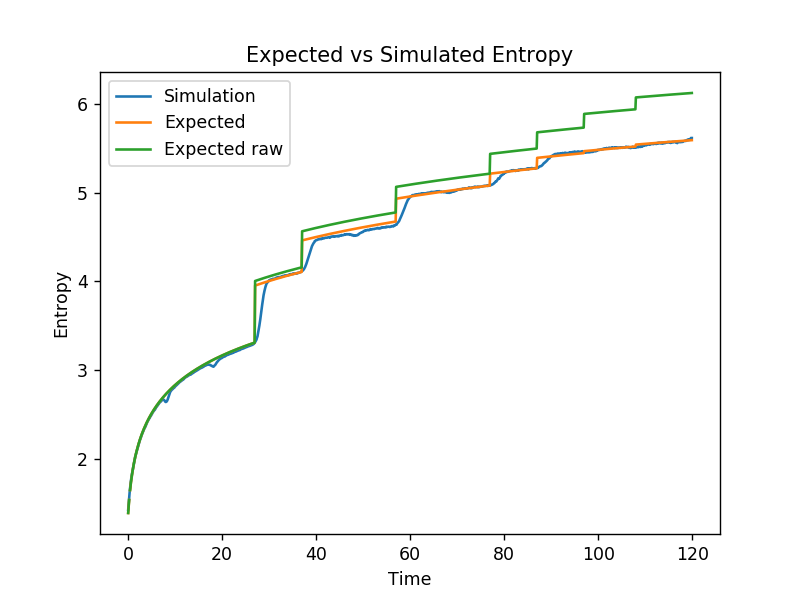

In [173]:
t = [dt*idx for idx in range(second_plot['h'].shape[0])]
fig, ax = plt.subplots()
ax.plot(t,second_plot['h'], label='Simulation')
ax.plot(t,second_plot['predicted_ent'], label='Expected')
ax.plot(t,predicted_ent_raw, label='Expected raw')
ax.set_title('Expected vs Simulated Entropy')
ax.set_ylabel('Entropy')
ax.set_xlabel('Time')
ax.legend()

<IPython.core.display.Javascript object>


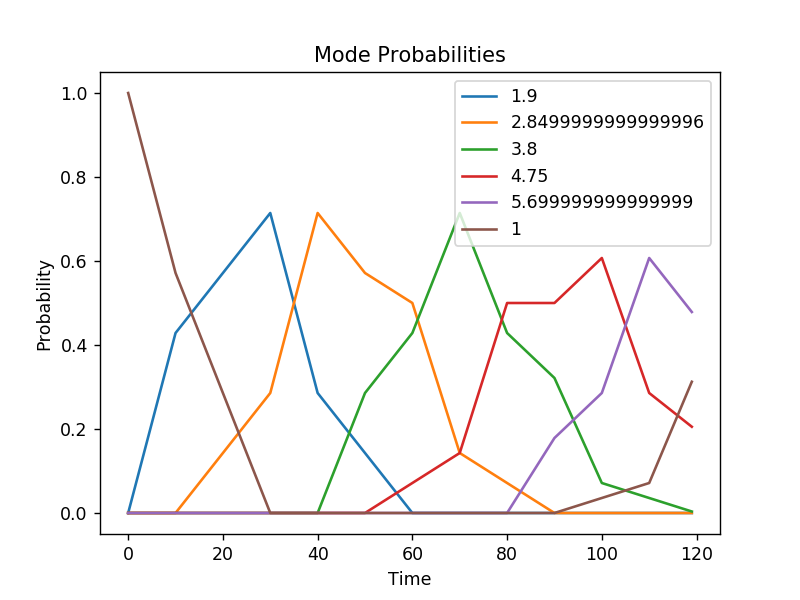

In [14]:
def get_time(t, ts, offset, initial_range):
    time = t - (ts + offset)
    time[np.where(time<0)] = 0
    time[np.where(time>initial_range)] = initial_range
    return time
def get_prob_of_mode_type(prob, initial_range, ts, options, base, t, level, desired_level):
    z = np.zeros((t.shape[0]))
    o = np.zeros((t.shape[0]))
    p = z
    num_options = len(options)
    next_prob = 1./num_options
    if level == desired_level:
        p = prob*get_time(t, ts, 0, initial_range)
        for idx in range(num_options):
            offset = base[options[idx]]['offset']
            p = p - prob*next_prob*get_time(t, ts, offset, initial_range)
#         p = 2**level * p
    else:
        first_death = t[-1]+1
        for idx in range(num_options):
            if level < desired_level:
                offset = base[options[idx]]['offset']
                next_options = base[options[idx]]['options']
                p = p + prob*get_prob_of_mode_type(next_prob, initial_range, ts+offset, next_options, base, t, level+1, desired_level)

    return p
def getModeProbabilities(prob, initial_range, base, t, max_level):
    probabilities = {}
    start_level = 2
    prob_sum = [1 for idx in t]
    for desired_level in range(start_level,max_level):
        probabilities[desired_level*.95] = [0 for idx in t]
        for idx in range(len(prob)):
            probabilities[desired_level*.95] += prob[idx]*(1./initial_range[idx])*get_prob_of_mode_type(
                1, initial_range[idx], 0, base[idx]['options'], base, t, start_level, desired_level)
        prob_sum -= probabilities[desired_level*.95]
    probabilities[1] = prob_sum
    return probabilities

t = np.array([i for i in range(120)])

base = {
    0: {'offset': 10,
       'options': [1,1]},
    1: {'offset': 30,
       'options': [0,1]}
}
sigma = 4
dt = .1

plt.figure()
plt.title("Mode Probabilities")
plt.ylabel('Probability')
plt.xlabel('Time')
probabilities = getModeProbabilities([1./7, 6./7], [10, 30], base, t, 7)
for key in probabilities.keys():
    plt.plot(t, probabilities[key], label=key)
plt.legend()

In [146]:
dist_e = 50.
nodes = [(0.,0.), (dist_e,0.), ( 2*dist_e, 0),
         (0.,dist_e), (dist_e, dist_e), (2*dist_e, dist_e)]#,
#          (0.,2*dist_e), (dist_e, 2*dist_e), (2*dist_e, 2*dist_e)]

edges = [(0, 1), (1,2), (0,3), (1,4), (2,5), (3,4), (4,5)]#, (3,6), (4,7), (5,8), (6,7), (7,8)]


N = 10
dt = 0.1
T_end = 65
num_runs = 100

P_fa = 0.02
P_miss = 0.05
v0 = 10
sigma = 4
# pf_args = {num_pa/ticles':N, 'dt':dt, 'v0':v0, 'sigma':4, 'P_fa':P_fa, 'P_miss':P_miss}
h, v = runIterations(nodes, edges, N, dt, T_end, num_runs, P_fa, P_miss,
                                v0=v0, sigma=4, num_targets=1, plot=False, entropy_res=1)

In [147]:
sigma = 4
try:
    v = third_plot['v']
except:
    pass
t = np.array([dt*idx for idx in range(h.shape[0])])

base = {
    0: {'offset': 5,
       'options': [1,1]},
    1: {'offset': 15,
       'options': [0,1]}
}

probabilities = getModeProbabilities([1./7, 6./7], [5, 15], base, t, 10)
probabilites_by_time = []
for idx in range(h.shape[0]):
    probabilites_by_time.append({})
    for key in probabilities.keys():
        probabilites_by_time[-1][key] = probabilities[key][idx]
map_size = 350
predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(v, map_size, dt, sigma,
                                                                 h.shape[0], probabilites_by_time)


/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [148]:
third_plot = {
    'h': h,
    'predicted_ent': predicted_ent,
    'v': v
}

<IPython.core.display.Javascript object>


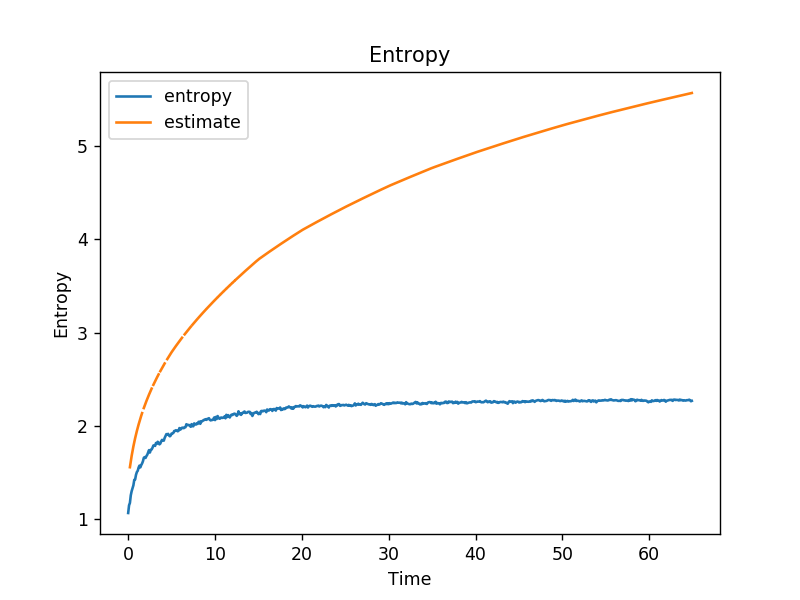

In [149]:
fig, ax = plt.subplots()
ax.set_title('Entropy')
ax.set_ylabel('Entropy')
ax.set_xlabel('Time')
pre_overlap = h.shape[0]-1
t = [dt*idx for idx in range(third_plot['h'].shape[0])]
ax.plot(t,third_plot['h'], label='entropy')
ax.plot(t,third_plot['predicted_ent'], label='estimate')
ax.legend()

In [115]:
dist_e = 100.
nodes = [(0.,0.), (dist_e,0.), ( 2*dist_e, 0),
         (0.,dist_e), (dist_e, dist_e), (2*dist_e, dist_e)]#,
#          (0.,2*dist_e), (dist_e, 2*dist_e), (2*dist_e, 2*dist_e)]

edges = [(0, 1), (1,2), (0,3), (1,4), (2,5), (3,4), (4,5)]#, (3,6), (4,7), (5,8), (6,7), (7,8)]


N = 1000
dt = 0.1
T_end = 120
num_runs = 10
sigma = 4

P_fa = 0.02
P_miss = 0.05
v0 = 10
# pf_args = {num_pa/ticles':N, 'dt':dt, 'v0':v0, 'sigma':4, 'P_fa':P_fa, 'P_miss':P_miss}
h, v = runIterations(nodes, edges, N, dt, T_end, num_runs, P_fa, P_miss,
                                v0=v0, sigma=sigma, num_targets=1, all_data=False, plot=False)

[((0.0, 0.0), (100.0, 0.0)), ((0.0, 0.0), (0.0, 100.0)), ((100.0, 0.0), (0.0, 0.0)), ((100.0, 0.0), (200.0, 0)), ((100.0, 0.0), (100.0, 100.0)), ((200.0, 0), (100.0, 0.0)), ((200.0, 0), (200.0, 100.0)), ((0.0, 100.0), (0.0, 0.0)), ((0.0, 100.0), (100.0, 100.0)), ((100.0, 100.0), (100.0, 0.0)), ((100.0, 100.0), (0.0, 100.0)), ((100.0, 100.0), (200.0, 100.0)), ((200.0, 100.0), (200.0, 0)), ((200.0, 100.0), (100.0, 100.0))]
((0.0, 0.0), (0.0, 100.0))
[((0.0, 0.0), (100.0, 0.0)), ((0.0, 0.0), (0.0, 100.0)), ((100.0, 0.0), (0.0, 0.0)), ((100.0, 0.0), (200.0, 0)), ((100.0, 0.0), (100.0, 100.0)), ((200.0, 0), (100.0, 0.0)), ((200.0, 0), (200.0, 100.0)), ((0.0, 100.0), (0.0, 0.0)), ((0.0, 100.0), (100.0, 100.0)), ((100.0, 100.0), (100.0, 0.0)), ((100.0, 100.0), (0.0, 100.0)), ((100.0, 100.0), (200.0, 100.0)), ((200.0, 100.0), (200.0, 0)), ((200.0, 100.0), (100.0, 100.0))]
((0.0, 0.0), (100.0, 0.0))


KeyboardInterrupt: 

In [ ]:
t = np.array([dt*idx for idx in range(h.shape[0])])
base = {
    0: {'offset': 10,
       'options': [1,1]},
    1: {'offset': 30,
       'options': [0,1]}
}
probabilities = getModeProbabilities([1./7, 6./7], [10, 30], base, t, 10)
probabilites_by_time = []
for idx in range(h.shape[0]):
    probabilites_by_time.append({})
    for key in probabilities.keys():
        probabilites_by_time[-1][key] = probabilities[key][idx]
predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(v, 100, dt, sigma,
                                                                 h.shape[0], probabilites_by_time)

In [ ]:
fourth_plot = {
    'h': h,
    'predicted_ent': predicted_ent,
    'v': v
}

<IPython.core.display.Javascript object>


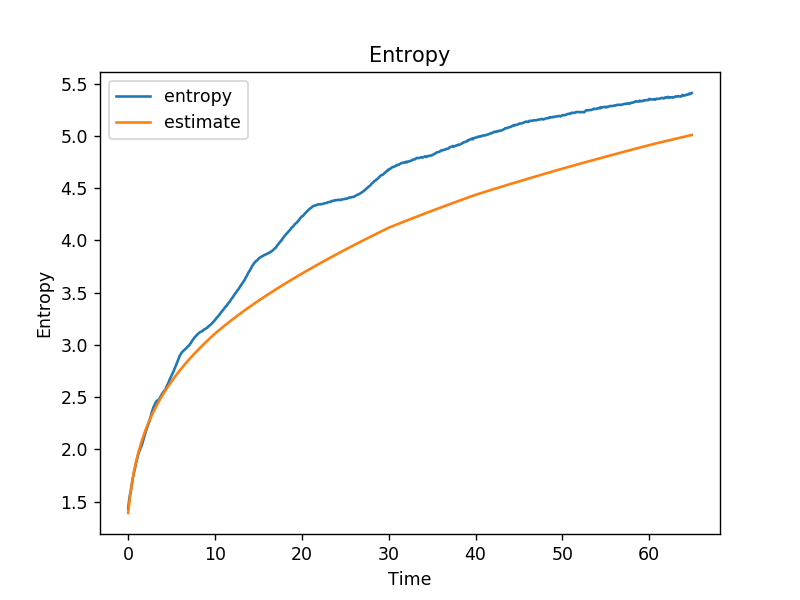

In [114]:
fig, ax = plt.subplots()
ax.set_title('Entropy')
ax.set_ylabel('Entropy')
ax.set_xlabel('Time')
pre_overlap = h.shape[0]-1
t = [dt*idx for idx in range(fourth_plot['h'].shape[0])]
ax.plot(t,fourth_plot['h'], label='entropy')
ax.plot(t,fourth_plot['predicted_ent'], label='estimate')
ax.legend()